# Tabulation of chemistry based on mixture fraction and reaction progress variable

In [1]:
# Import basic libraries
import math
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.style.use('default')
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# Define path to PyTools classes
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../src/TabulatedChemistry')

# Import PyTools classes
from KineticMechanism import KineticMechanism
from OpenSMOKEppXMLFile import OpenSMOKEppXMLFile
from LaminarFlame1D import LaminarFlame1D
from PolimiSootModule import *
from Utilities import *
from TabulationChemistryUtilities import *
from TableNormalizedMixFractionAndRPV import TableNormalizedMixFractionAndRPV

### Input data

Output options

In [2]:
# Output folder name
output_folder = 'Plots\\'

# Write table on file
write_xml = 1

Table size (number of points in each direction)

In [3]:
npts_Z = 201
npts_y = 201

Progress variable definition

In [4]:
alpha = [ ['H2O', 1.],
          ['CO2', 1.],
          ['H2', 0.35],
          ['CO', 1.],
          ['O2', 0.1],
          ['PAH12', 0.],
          ['PAH34', 0.],
          ['PAHLP', 0.],
          ['SP', 0.],
        ]

Path to kinetic mechanism

In [5]:
# Path to kinetic mechanism
kin_main_folder="C:\\Users\\acuoci\\OneDrive - Politecnico di Milano\\My Projects\\GitHub\\CRECK_DiscreteSectionalModel_v2012\\CRECK_2012_Soot_OnlyBINJ_NoHeavyFuels\\"
kin_xml_file_name=kin_main_folder+"kinetics-CRECK_2012_SootOnlyBINJ-PAH12\\kinetics.xml"
#kin_xml_file_name=kin_main_folder+"kinetics-CRECK_2012_SootOnlyBINJ-PAH34\\kinetics.xml"
#kin_xml_file_name=kin_main_folder+"kinetics-CRECK_2012_SootOnlyBINJ-PAHLP\\kinetics.xml"
#kin_xml_file_name=kin_main_folder+"kinetics-CRECK_2012_SootOnlyBINJ-SP\\kinetics.xml"
#kin_xml_file_name=kin_main_folder+"kinetics-CRECK_2012_SootOnlyBINJ-SP-AGG\\kinetics.xml"

Flamelets to import

In [6]:
# Path to data
flamelets_main_folder_name = "C:\\Users\\acuoci\\Aachen-Data\\Simulations\\Flamelets\\C2H4_100_N2_000\\CRECK_2012\\"
flamelets_folder_name = flamelets_main_folder_name + "02-CRECK_2012_SootOnlyBINJ_NoHeavyFuels_PAH12\\"
#flamelets_name = flamelets_main_folder_name + "03-CRECK_2012_SootOnlyBINJ_NoHeavyFuels_PAH34\\"
#flamelets_name = flamelets_main_folder_name + "04-CRECK_2012_SootOnlyBINJ_NoHeavyFuels_PAHLP\\"
#flamelets_name = flamelets_main_folder_name + "05-CRECK_2012_SootOnlyBINJ_NoHeavyFuels_SP\\"
#flamelets_name = flamelets_main_folder_name + "02-CRECK_2012_SootOnlyBINJ_NoHeavyFuels_SP-AGG\\"

# 1- Steady-state solutions
list_steady = [];
list_steady.append('0.02')
list_steady.append('0.05')
list_steady.append('0.1')
list_steady.append('0.2')
list_steady.append('0.5')
list_steady.append('1')
list_steady.append('2')
list_steady.append('5')
list_steady.append('10')
list_steady.append('20')
list_steady.append('50')
list_steady.append('100')
list_steady.append('150')
nflames_steady = len(list_steady)

# 2- Extinction solutions
list_extinctions = [];
list_extinctions.append('1800')
list_extinctions.append('1750')
list_extinctions.append('1700')
list_extinctions.append('1600')
list_extinctions.append('1400')
list_extinctions.append('1200')
list_extinctions.append('1000')
list_extinctions.append('800')
list_extinctions.append('600')
list_extinctions.append('400')
nflames_dynamics = len(list_extinctions)

# 3- Final cold solution
cold_flamelet_name = flamelets_folder_name + "Output_Cold_0_kJkg.xml"

Counterflow diffusion flames for a priori validation

In [7]:
cfdf_folder_name = "C:\\Users\\acuoci\\Aachen-Data\\Simulations\\CFDF\\C2H4_100_N2_000\\CRECK_2012\\"
sub_cfdf_folder_name = "02-CRECK_2012_SootOnlyBINJ_NoHeavyFuels_PAH12\\"
#sub_cfdf_folder_name = "03-CRECK_2012_SootOnlyBINJ_NoHeavyFuels_PAH34\\"
#sub_cfdf_folder_name = "04-CRECK_2012_SootOnlyBINJ_NoHeavyFuels_PAHLP\\"
#sub_cfdf_folder_name = "05-CRECK_2012_SootOnlyBINJ_NoHeavyFuels_SP\\"
#sub_cfdf_folder_name = "06-CRECK_2012_SootOnlyBINJ_NoHeavyFuels_SP-AGG\\"
    
sol_xml_file_names = []
sol_xml_file_names.append(cfdf_folder_name + "a025Hz\\" + sub_cfdf_folder_name + "Output\\Output.xml")
sol_xml_file_names.append(cfdf_folder_name + "a035Hz\\" + sub_cfdf_folder_name + "Output\\Output.xml")
sol_xml_file_names.append(cfdf_folder_name + "a045Hz\\" + sub_cfdf_folder_name + "Output\\Output.xml")
sol_xml_file_names.append(cfdf_folder_name + "a055Hz\\" + sub_cfdf_folder_name + "Output\\Output.xml")
sol_xml_file_names.append(cfdf_folder_name + "a065Hz\\" + sub_cfdf_folder_name + "Output\\Output.xml")

## Tabulation

In [8]:
# Read kinetic mechanism
kinetics = KineticMechanism(kin_xml_file_name)

In [9]:
# Define groups of species
kinetics.AddGroupOfSpecies('PAH12', 'PAHs with 1/2 aromatic rings', DefaultPAH12())
kinetics.AddGroupOfSpecies('PAH34', 'PAHs with 3/4 aromatic rings', DefaultPAH34())
kinetics.AddGroupOfSpecies('PAHLP', 'PAHs with more than 4 aromatic rings (molecular and radical)', DefaultPAHLP(kinetics.species))
kinetics.AddGroupOfSpecies('PAHLP-M', 'PAHs with more than 4 aromatic rings (molecular)', DefaultPAHLPM(kinetics.species))
kinetics.AddGroupOfSpecies('PAHLP-R', 'PAHs with more than 4 aromatic rings (radical)', DefaultPAHLPR(kinetics.species))
kinetics.AddGroupOfSpecies('SP', 'BIN sections corresponding to spherical particles (molecular and radical)', DefaultSP(kinetics.species))
kinetics.AddGroupOfSpecies('SP-M', 'BIN sections corresponding to spherical particles (molecular)', DefaultSPM(kinetics.species))
kinetics.AddGroupOfSpecies('SP-R', 'BIN sections corresponding to spherical particles (radical)', DefaultSPR(kinetics.species))
kinetics.AddGroupOfSpecies('AGG', 'BIN sections corresponding to aggregates (molecular and radical)', DefaultAGG(kinetics.species))
kinetics.AddGroupOfSpecies('AGG-M', 'BIN sections corresponding to aggregates (molecular)', DefaultAGGM(kinetics.species))
kinetics.AddGroupOfSpecies('AGG-R', 'BIN sections corresponding to aggregates (radical)', DefaultAGGR(kinetics.species))

In [10]:
# Collecting steady-state flames
flames = []
for i in range(nflames_steady):
    sol_xml_file_name = flamelets_folder_name + "Output_" + list_steady[i] + "_Hz_0_kJkg.xml"
    flames.append( LaminarFlame1D(sol_xml_file_name, kinetics) )

# Collecting dynamic flames
for i in range(nflames_dynamics):
    sol_xml_file_name = flamelets_folder_name + "Dynamics_" + list_extinctions[i] + "_K.xml"
    flames.append( LaminarFlame1D(sol_xml_file_name, kinetics) )

# Cold flame
flames.append( LaminarFlame1D(cold_flamelet_name, kinetics) )

# Total number of flames
nflames = len(flames)

no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in the xml file
no reaction-rates available in t

In [11]:
# Create plot folder (if it does not exist)
from pathlib import Path
Path(output_folder).mkdir(parents=True, exist_ok=True)

In [12]:
for i in range(nflames):
    LaminarFlame1D.progress_variable(flames[i], kinetics, alpha)

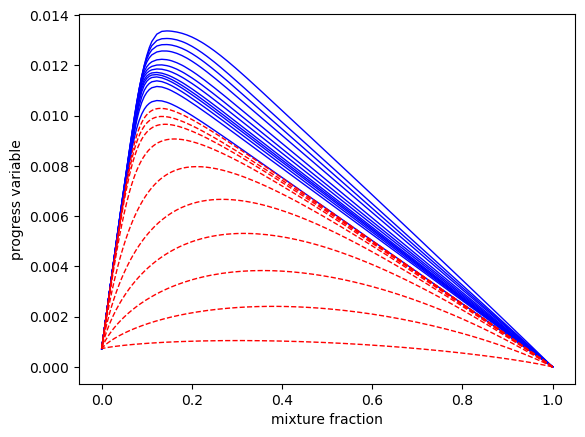

In [13]:
# Plot the progress variable curves as a function of the mixture fraction
for i in range(nflames_steady):
    plt.plot(flames[i].Z,flames[i].y, linestyle='-', linewidth=1, color='blue')
for i in range(nflames_dynamics):
    plt.plot(flames[nflames_steady+i].Z,flames[nflames_steady+i].y, linestyle='--', linewidth=1, color='red')
plt.xlabel("mixture fraction")
plt.ylabel("progress variable")
plt.savefig(output_folder +'flamelets_Y')

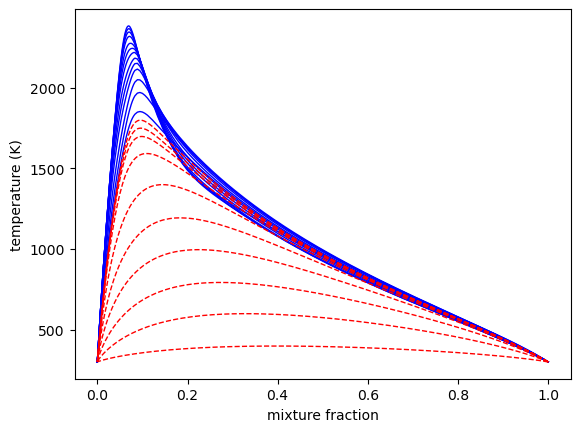

In [14]:
# Plot the temperature curves as a function of the mixture fraction
for i in range(nflames_steady):
    plt.plot(flames[i].Z,flames[i].T, linestyle='-', linewidth=1, color='blue')
for i in range(nflames_dynamics):
    plt.plot(flames[nflames_steady+i].Z,flames[nflames_steady+i].T, linestyle='--', linewidth=1, color='red')
plt.xlabel("mixture fraction")
plt.ylabel("temperature (K)")
plt.savefig(output_folder +'flamelets_T')

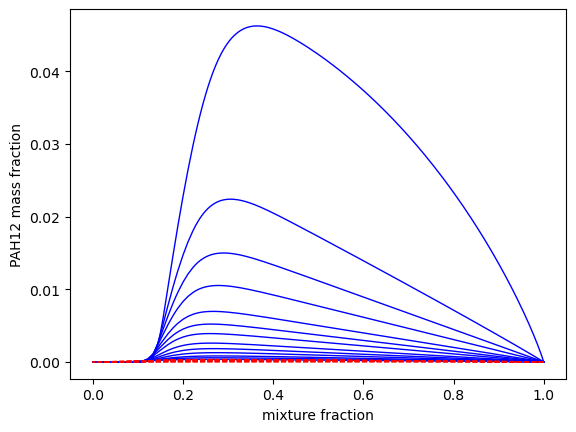

In [15]:
# Plot the PAH12 curves as a function of the mixture fraction
for i in range(nflames_steady):
    plt.plot(flames[i].Z,flames[i].pah12_Y, linestyle='-', linewidth=1, color='blue')
for i in range(nflames_dynamics):
    plt.plot(flames[nflames_steady+i].Z,flames[nflames_steady+i].pah12_Y, linestyle='--', linewidth=1, color='red')
plt.xlabel("mixture fraction")
plt.ylabel("PAH12 mass fraction")
plt.savefig(output_folder +'flamelets_PAH12')

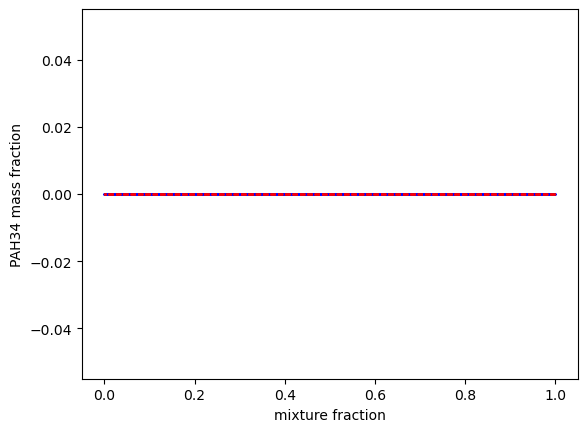

In [16]:
# Plot the PAH34 curves as a function of the mixture fraction
for i in range(nflames_steady):
    plt.plot(flames[i].Z,flames[i].pah34_Y, linestyle='-', linewidth=1, color='blue')
for i in range(nflames_dynamics):
    plt.plot(flames[nflames_steady+i].Z,flames[nflames_steady+i].pah34_Y, linestyle='--', linewidth=1, color='red')
plt.xlabel("mixture fraction")
plt.ylabel("PAH34 mass fraction")
plt.savefig(output_folder +'flamelets_PAH34')

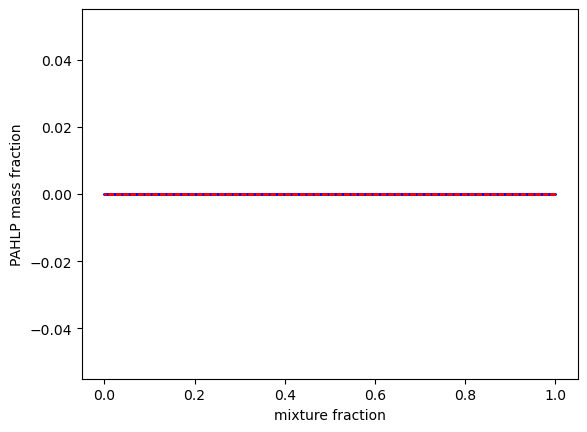

In [17]:
# Plot the PAHLP curves as a function of the mixture fraction
for i in range(nflames_steady):
    plt.plot(flames[i].Z,flames[i].pahlp_Y, linestyle='-', linewidth=1, color='blue')
for i in range(nflames_dynamics):
    plt.plot(flames[nflames_steady+i].Z,flames[nflames_steady+i].pahlp_Y, linestyle='--', linewidth=1, color='red')
#plt.yscale('log')
plt.xlabel("mixture fraction")
plt.ylabel("PAHLP mass fraction")
plt.savefig(output_folder +'flamelets_PAHLP')

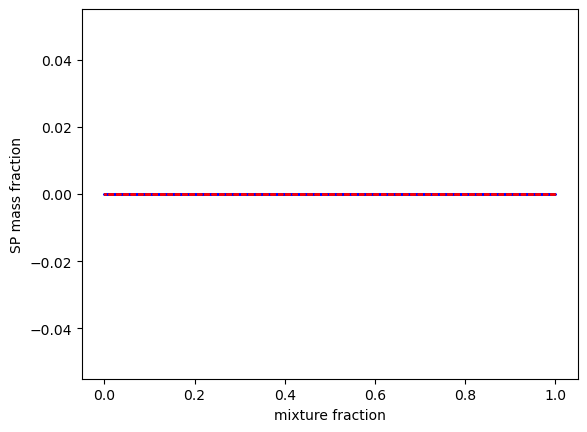

In [18]:
# Plot the SP curves as a function of the mixture fraction
for i in range(nflames_steady):
    plt.plot(flames[i].Z,flames[i].sp_Y, linestyle='-', linewidth=1, color='blue')
for i in range(nflames_dynamics):
    plt.plot(flames[nflames_steady+i].Z,flames[nflames_steady+i].sp_Y, linestyle='--', linewidth=1, color='red')
#plt.yscale('log')
plt.xlabel("mixture fraction")
plt.ylabel("SP mass fraction")
plt.savefig(output_folder +'flamelets_SP')

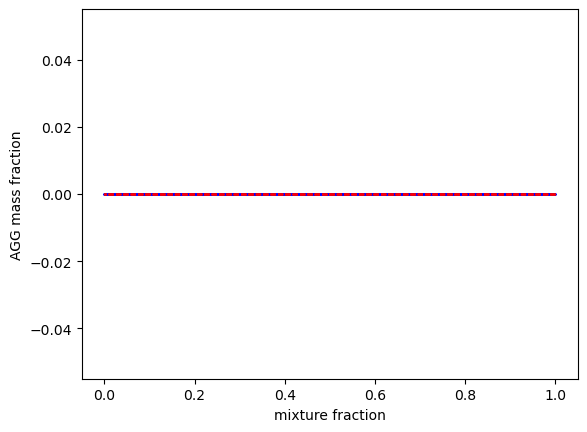

In [19]:
# Plot the AGG curves as a function of the mixture fraction
for i in range(nflames_steady):
    plt.plot(flames[i].Z,flames[i].agg_Y, linestyle='-', linewidth=1, color='blue')
for i in range(nflames_dynamics):
    plt.plot(flames[nflames_steady+i].Z,flames[nflames_steady+i].agg_Y, linestyle='--', linewidth=1, color='red')
#plt.yscale('log')
plt.xlabel("mixture fraction")
plt.ylabel("AGG mass fraction")
plt.savefig(output_folder +'flamelets_AGG')

In [20]:
minmax_y = []
for i in range(nflames):
    minmax_y.append(flames[i].minmax_progress_variable())
    
min_y = min(np.array(minmax_y)[:,0])
max_y = max(np.array(minmax_y)[:,1])

for i in range(nflames):
    flames[i].create_grid(kinetics, [npts_Z, npts_y], [0.,min_y], [1.,max_y] )

In [21]:
# Check for monotonicity
threshold = 1e-12
nviolations = []

# Loop over the mixture fraction points
for k in range(npts_Z):
    
    # Get progress variables at given mixture fraction
    y_values = []
    for i in range(nflames):
        y_values.append( flames[i].y_int_Z[k] )
    
    # Local number of violations
    n = 0
    for i in range(nflames-1):
        if ( (y_values[i+1] -y_values[i]) > threshold ) : n = n+1
    nviolations.append(n)
    if (n > 0): print(flames[0].Z_grid[k], n)

np.sum(nviolations)

0.005 5
0.04 1
0.045 1
0.05 1
0.055 1
0.06 1


10

In [22]:
tableNorm_T = TableNormalizedMixFractionAndRPV(kinetics, flames,'T')
tableNorm_Omegay = TableNormalizedMixFractionAndRPV(kinetics, flames,'Omegay')
tableNorm_CO2 = TableNormalizedMixFractionAndRPV(kinetics, flames,'CO2')
tableNorm_CO = TableNormalizedMixFractionAndRPV(kinetics, flames,'CO')
tableNorm_H2 = TableNormalizedMixFractionAndRPV(kinetics, flames,'H2')
tableNorm_H2O = TableNormalizedMixFractionAndRPV(kinetics, flames,'H2O')
tableNorm_C2H2 = TableNormalizedMixFractionAndRPV(kinetics, flames,'C2H2')
tableNorm_PAH12 = TableNormalizedMixFractionAndRPV(kinetics, flames,'PAH12')
tableNorm_PAH34 = TableNormalizedMixFractionAndRPV(kinetics, flames,'PAH34')
tableNorm_PAHLP = TableNormalizedMixFractionAndRPV(kinetics, flames,'PAHLP')
tableNorm_SP = TableNormalizedMixFractionAndRPV(kinetics, flames,'SP')
tableNorm_AGG = TableNormalizedMixFractionAndRPV(kinetics, flames,'AGG')

CPU time (s):  0.09375
CPU time (s):  0.0625
CPU time (s):  0.0625
CPU time (s):  0.046875
CPU time (s):  0.078125
CPU time (s):  0.078125
CPU time (s):  0.0625
CPU time (s):  0.0625
CPU time (s):  0.046875
CPU time (s):  0.0625
CPU time (s):  0.0625
CPU time (s):  0.0625


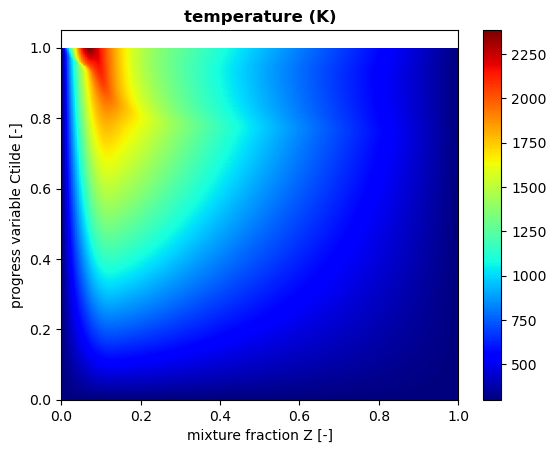

In [23]:
tableNorm_T.PlotMapTilde("temperature (K)", output_folder, "Map2D_Temperature")

CPU time (s):  0.046875


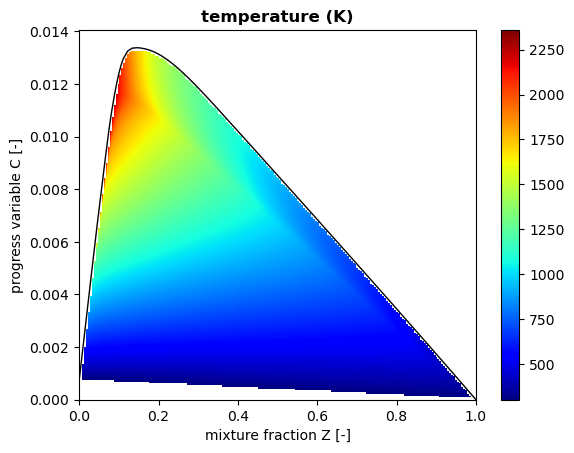

In [24]:
tableNorm_T.BuildTableForGraphicalPurposes(kinetics, flames)
tableNorm_T.PlotMap("temperature (K)", output_folder, "Map2D_Temperature")

CPU time (s):  0.03125


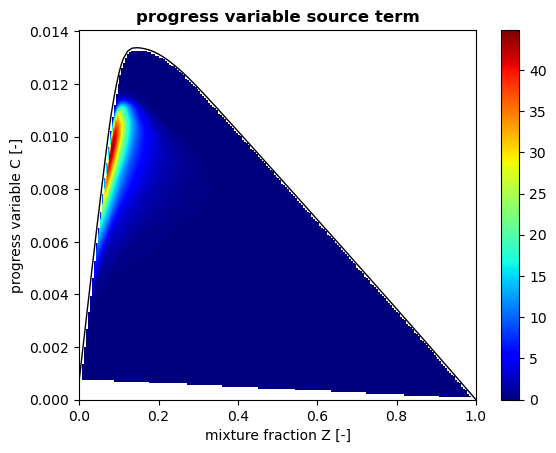

In [25]:
tableNorm_Omegay.BuildTableForGraphicalPurposes(kinetics, flames)
tableNorm_Omegay.PlotMap("progress variable source term", output_folder, "Map2D_Omegay")

CPU time (s):  0.03125


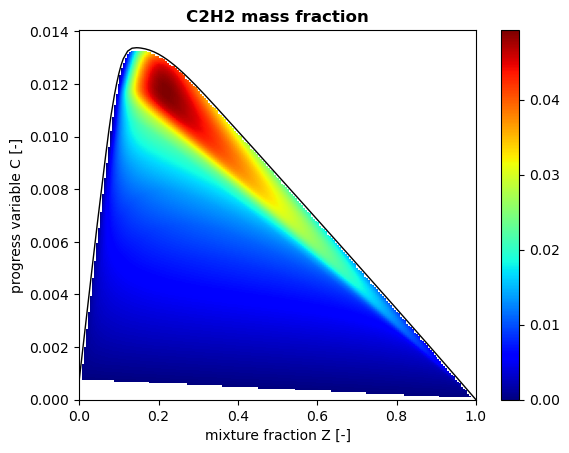

In [26]:
tableNorm_C2H2.BuildTableForGraphicalPurposes(kinetics, flames)
tableNorm_C2H2.PlotMap("C2H2 mass fraction", output_folder, "Map2D_C2H2")

CPU time (s):  0.0625


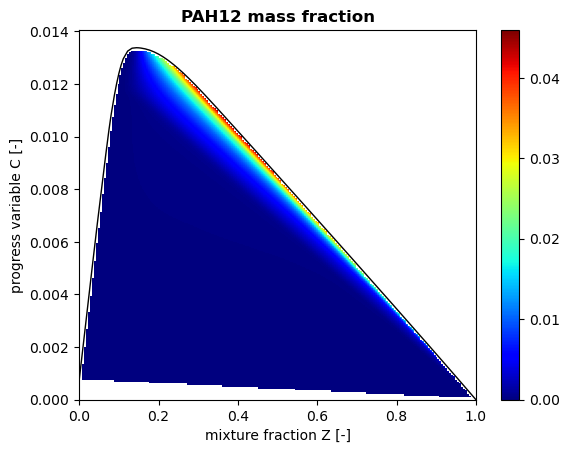

In [27]:
tableNorm_PAH12.BuildTableForGraphicalPurposes(kinetics, flames)
tableNorm_PAH12.PlotMap("PAH12 mass fraction", output_folder, "Map2D_PAH12")

CPU time (s):  0.0625


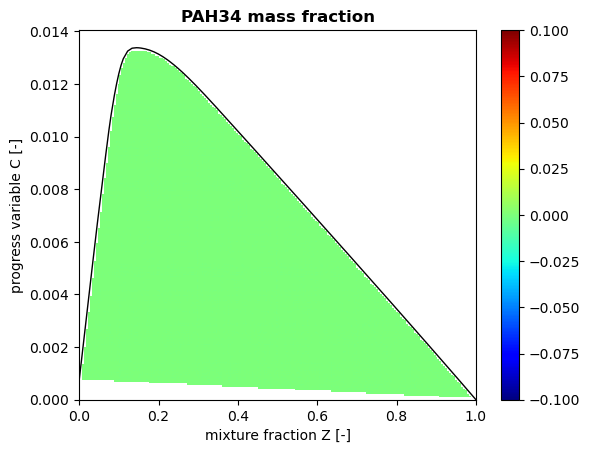

In [28]:
tableNorm_PAH34.BuildTableForGraphicalPurposes(kinetics, flames)
tableNorm_PAH34.PlotMap("PAH34 mass fraction", output_folder, "Map2D_PAH34")

CPU time (s):  0.03125


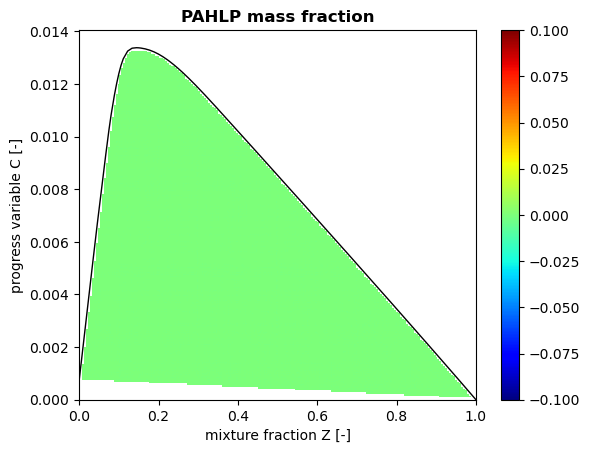

In [29]:
tableNorm_PAHLP.BuildTableForGraphicalPurposes(kinetics, flames)
tableNorm_PAHLP.PlotMap("PAHLP mass fraction", output_folder, "Map2D_PAHLP")

CPU time (s):  0.046875


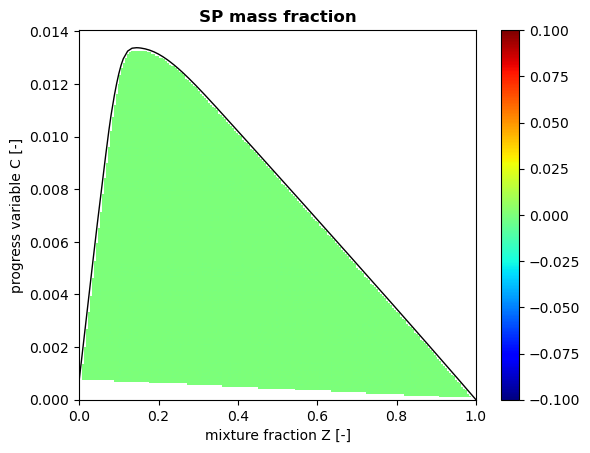

In [30]:
tableNorm_SP.BuildTableForGraphicalPurposes(kinetics, flames)
tableNorm_SP.PlotMap("SP mass fraction", output_folder, "Map2D_SP")

CPU time (s):  0.078125


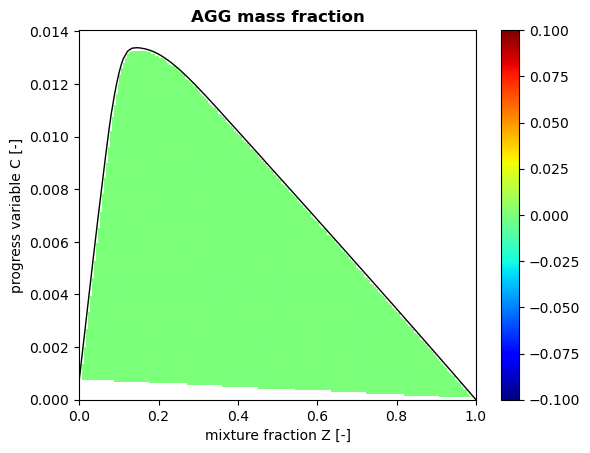

In [31]:
tableNorm_AGG.BuildTableForGraphicalPurposes(kinetics, flames)
tableNorm_AGG.PlotMap("AGG mass fraction", output_folder, "Map2D_AGG")

In [32]:
if write_xml == 1:
    
    PrintMainLookupTable(kinetics, flames, alpha, output_folder)
    
    tableNorm_T.PrintLookupTable(output_folder, "T")
    tableNorm_Omegay.PrintLookupTable(output_folder, "Omegay")
    tableNorm_CO2.PrintLookupTable(output_folder, "CO2")
    tableNorm_CO.PrintLookupTable(output_folder, "CO")
    tableNorm_H2.PrintLookupTable(output_folder, "H2")
    tableNorm_H2O.PrintLookupTable(output_folder, "H2O")
    tableNorm_C2H2.PrintLookupTable(output_folder, "C2H2")
    tableNorm_PAH12.PrintLookupTable(output_folder, "PAH12")
    tableNorm_PAH34.PrintLookupTable(output_folder, "PAH34")
    tableNorm_PAHLP.PrintLookupTable(output_folder, "PAHLP")
    tableNorm_SP.PrintLookupTable(output_folder, "SP")
    tableNorm_AGG.PrintLookupTable(output_folder, "AGG")

Lookup table:  T
Lookup table:  Omegay
Lookup table:  CO2
Lookup table:  CO
Lookup table:  H2
Lookup table:  H2O
Lookup table:  C2H2
Lookup table:  PAH12
Lookup table:  PAH34
Lookup table:  PAHLP
Lookup table:  SP
Lookup table:  AGG


## A-priori validation (reconstruction on laminar counterflow diffusion flames)

In [33]:
cfdf = []
for name in sol_xml_file_names:
    cfdf.append( LaminarFlame1D(name, kinetics) )

ncfdf = len(cfdf)
for i in range(ncfdf):
    LaminarFlame1D.progress_variable(cfdf[i], kinetics, alpha)

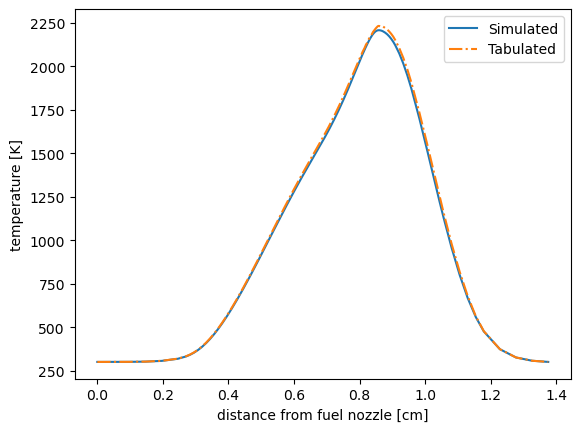

In [34]:
reconNorm_T = tableNorm_T.Reconstruct(cfdf[0].Z, cfdf[0].y)
plt.plot(cfdf[0].x, cfdf[0].T)
plt.plot(cfdf[0].x, reconNorm_T, linestyle='-.')
plt.xlabel('distance from fuel nozzle [cm]')
plt.ylabel('temperature [K]')
plt.legend(['Simulated', 'Tabulated'])

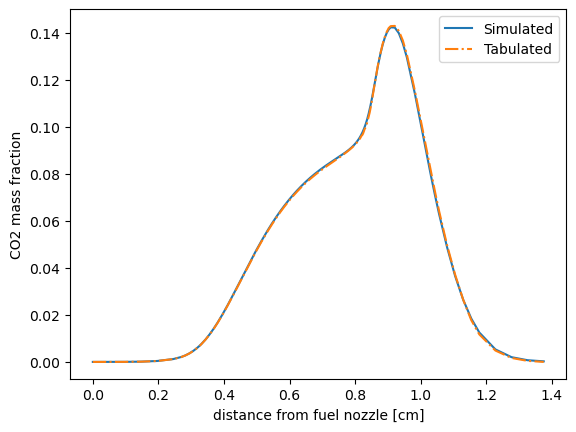

In [35]:
iCO2 = kinetics.species.index('CO2')
reconNorm_CO2 = tableNorm_CO2.Reconstruct(cfdf[0].Z, cfdf[0].y)
plt.plot(cfdf[0].x, cfdf[0].Y[:,iCO2])
plt.plot(cfdf[0].x, reconNorm_CO2, linestyle='-.')
plt.xlabel('distance from fuel nozzle [cm]')
plt.ylabel('CO2 mass fraction')
plt.legend(['Simulated', 'Tabulated'])

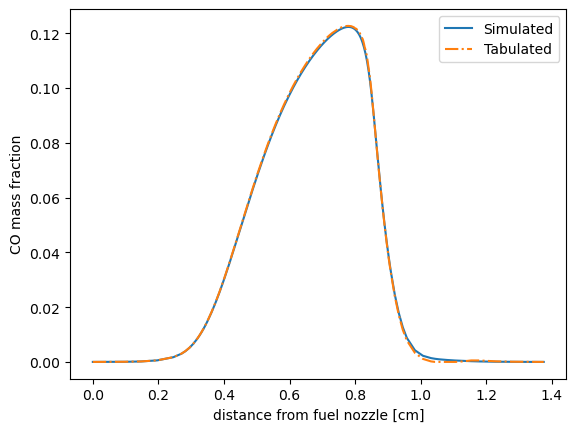

In [36]:
iCO = kinetics.species.index('CO')
reconNorm_CO = tableNorm_CO.Reconstruct(cfdf[0].Z, cfdf[0].y)
plt.plot(cfdf[0].x, cfdf[0].Y[:,iCO])
plt.plot(cfdf[0].x, reconNorm_CO, linestyle='-.')
plt.xlabel('distance from fuel nozzle [cm]')
plt.ylabel('CO mass fraction')
plt.legend(['Simulated', 'Tabulated'])

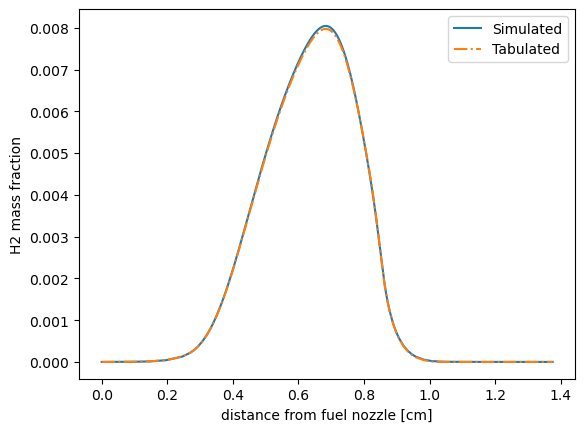

In [37]:
iH2 = kinetics.species.index('H2')
reconNorm_H2 = tableNorm_H2.Reconstruct(cfdf[0].Z, cfdf[0].y)
plt.plot(cfdf[0].x, cfdf[0].Y[:,iH2])
plt.plot(cfdf[0].x, reconNorm_H2, linestyle='-.')
plt.xlabel('distance from fuel nozzle [cm]')
plt.ylabel('H2 mass fraction')
plt.legend(['Simulated', 'Tabulated'])

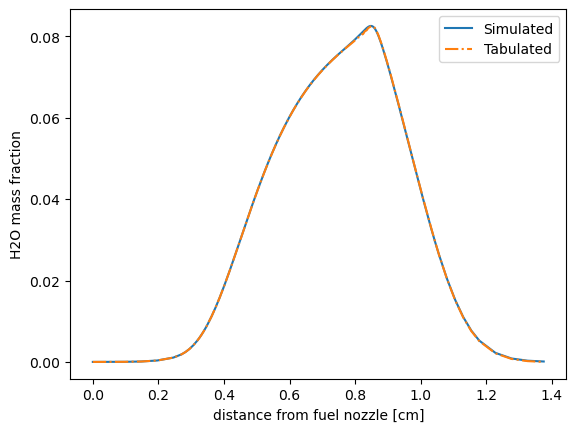

In [38]:
iH2O = kinetics.species.index('H2O')
reconNorm_H2O = tableNorm_H2O.Reconstruct(cfdf[0].Z, cfdf[0].y)
plt.plot(cfdf[0].x, cfdf[0].Y[:,iH2O])
plt.plot(cfdf[0].x, reconNorm_H2O, linestyle='-.')
plt.xlabel('distance from fuel nozzle [cm]')
plt.ylabel('H2O mass fraction')
plt.legend(['Simulated', 'Tabulated'])

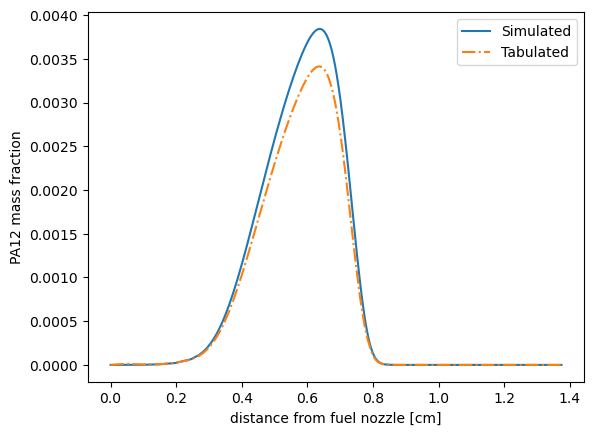

In [39]:
reconNorm_PAH12 = tableNorm_PAH12.Reconstruct(cfdf[0].Z, cfdf[0].y)
plt.plot(cfdf[0].x, cfdf[0].pah12_Y)
plt.plot(cfdf[0].x, reconNorm_PAH12, linestyle='-.')
plt.xlabel('distance from fuel nozzle [cm]')
plt.ylabel('PA12 mass fraction')
plt.legend(['Simulated', 'Tabulated'])

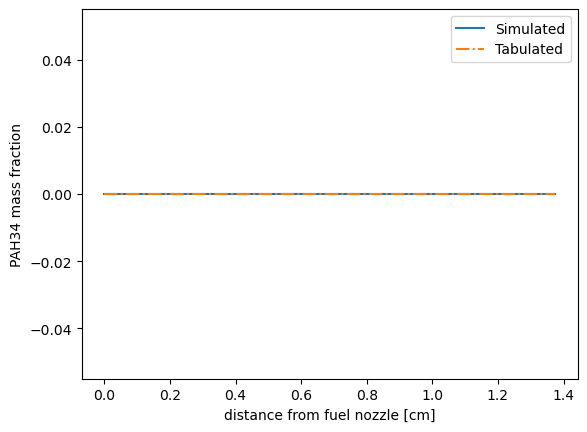

In [40]:
reconNorm_PAH34 = tableNorm_PAH34.Reconstruct(cfdf[0].Z, cfdf[0].y)
plt.plot(cfdf[0].x, cfdf[0].pah34_Y)
plt.plot(cfdf[0].x, reconNorm_PAH34, linestyle='-.')
plt.xlabel('distance from fuel nozzle [cm]')
plt.ylabel('PAH34 mass fraction')
plt.legend(['Simulated', 'Tabulated'])

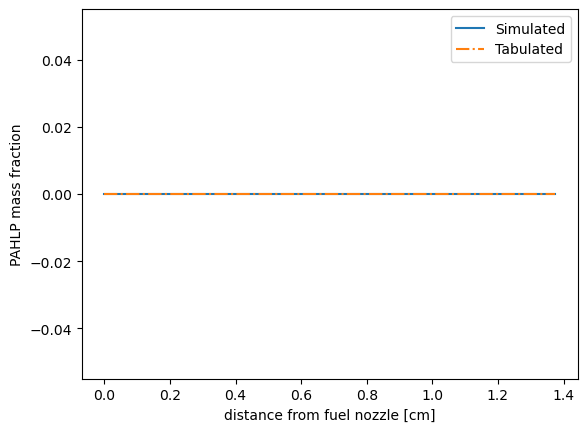

In [41]:
reconNorm_PAHLP = tableNorm_PAHLP.Reconstruct(cfdf[0].Z, cfdf[0].y)
plt.plot(cfdf[0].x, cfdf[0].pahlp_Y)
plt.plot(cfdf[0].x, reconNorm_PAHLP, linestyle='-.')
plt.xlabel('distance from fuel nozzle [cm]')
plt.ylabel('PAHLP mass fraction')
plt.legend(['Simulated', 'Tabulated'])

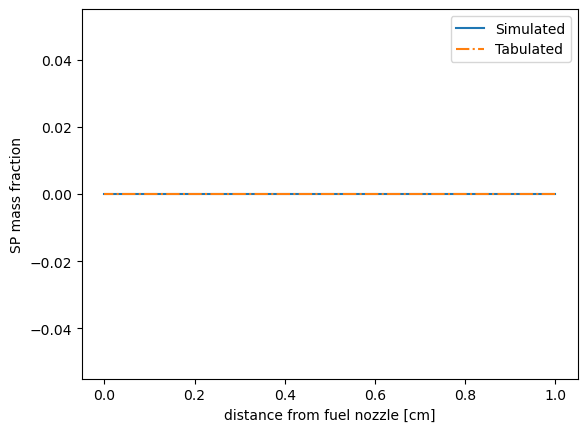

In [42]:
reconNorm_SP = tableNorm_SP.Reconstruct(cfdf[0].Z, cfdf[0].y)
plt.plot(cfdf[0].csi, cfdf[0].sp_Y)
plt.plot(cfdf[0].csi, reconNorm_SP, linestyle='-.')
plt.xlabel('distance from fuel nozzle [cm]')
plt.ylabel('SP mass fraction')
plt.legend(['Simulated', 'Tabulated'])

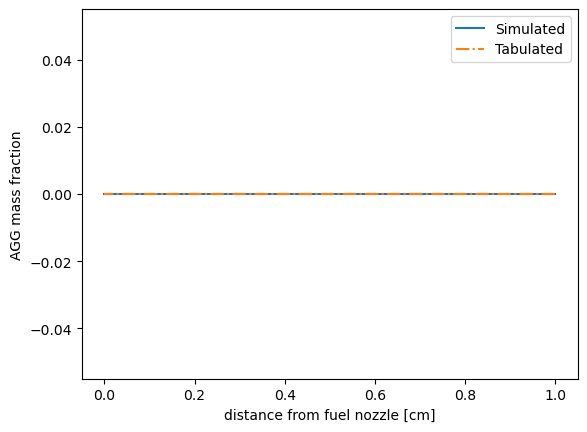

In [43]:
reconNorm_AGG = tableNorm_AGG.Reconstruct(cfdf[0].Z, cfdf[0].y)
plt.plot(cfdf[0].csi, cfdf[0].agg_Y)
plt.plot(cfdf[0].csi, reconNorm_AGG, linestyle='-.')
plt.xlabel('distance from fuel nozzle [cm]')
plt.ylabel('AGG mass fraction')
plt.legend(['Simulated', 'Tabulated'])

In [44]:
def ReconstructSolutions():
    
    recon_T = []
    for i in range(ncfdf):
        recon_T.append ( tableNorm_T.Reconstruct(cfdf[i].Z, cfdf[i].y) )

    recon_Y_CO2 = []
    iCO2 = kinetics.species.index('CO2')
    for i in range(ncfdf):
        recon_Y_CO2.append ( tableNorm_CO2.Reconstruct(cfdf[i].Z, cfdf[i].y) )

    recon_Y_CO = []
    iCO = kinetics.species.index('CO')
    for i in range(ncfdf):
        recon_Y_CO.append ( tableNorm_CO.Reconstruct(cfdf[i].Z, cfdf[i].y) )

    recon_Y_H2 = []
    iH2 = kinetics.species.index('H2')
    for i in range(ncfdf):
        recon_Y_H2.append ( tableNorm_H2.Reconstruct(cfdf[i].Z, cfdf[i].y) )

    recon_Y_H2O = []
    iH2O = kinetics.species.index('H2O')
    for i in range(ncfdf):
        recon_Y_H2O.append ( tableNorm_H2O.Reconstruct(cfdf[i].Z, cfdf[i].y) )

    recon_Y_C2H2 = []
    iC2H2 = kinetics.species.index('C2H2')
    for i in range(ncfdf):
        recon_Y_C2H2.append ( tableNorm_C2H2.Reconstruct(cfdf[i].Z, cfdf[i].y) )

    recon_Y_PAH12 = []
    for i in range(ncfdf):
        recon_Y_PAH12.append ( tableNorm_PAH12.Reconstruct(cfdf[i].Z, cfdf[i].y) )

    recon_Y_PAH34 = []
    for i in range(ncfdf):
        recon_Y_PAH34.append ( tableNorm_PAH34.Reconstruct(cfdf[i].Z, cfdf[i].y) )

    recon_Y_PAHLP = []
    for i in range(ncfdf):
        recon_Y_PAHLP.append ( tableNorm_PAHLP.Reconstruct(cfdf[i].Z, cfdf[i].y) )
        
    recon_Y_SP = []
    for i in range(ncfdf):
        recon_Y_SP.append ( tableNorm_SP.Reconstruct(cfdf[i].Z, cfdf[i].y) )
        
    recon_Y_AGG = []
    for i in range(ncfdf):
        recon_Y_AGG.append ( tableNorm_AGG.Reconstruct(cfdf[i].Z, cfdf[i].y) )

    return recon_T, recon_Y_CO2, recon_Y_CO,recon_Y_H2, recon_Y_H2O, recon_Y_C2H2, recon_Y_PAH12, recon_Y_PAH34, recon_Y_PAHLP, recon_Y_SP, recon_Y_AGG

In [45]:
recon_T, recon_Y_CO2, recon_Y_CO,recon_Y_H2, recon_Y_H2O, recon_Y_C2H2, recon_Y_PAH12, recon_Y_PAH34, recon_Y_PAHLP, recon_Y_SP, recon_Y_AGG = ReconstructSolutions()

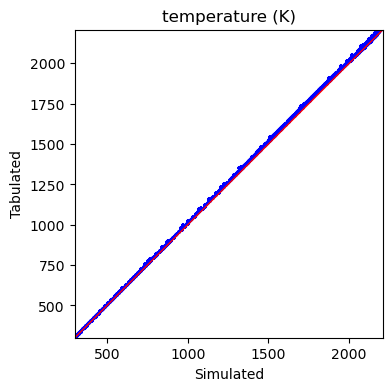

In [46]:
ScatterPlotMultipleFlames(kinetics, cfdf, "T", recon_T, "temperature (K)", output_folder, "Scatter_T")
#PlotProfile(cfdf[0].Z, cfdf[0].T, cfdf[0].Z, recon_T[0], "temperature (K)", "mixture fraction", "temperature (K)", output_folder, "Profiles_T")

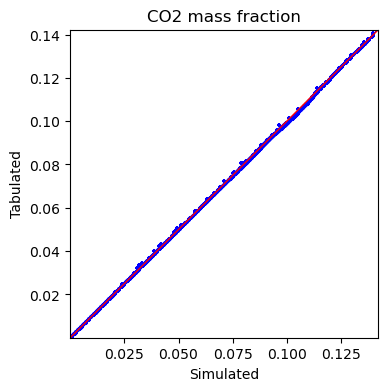

In [47]:
ScatterPlotMultipleFlames(kinetics, cfdf, "CO2", recon_Y_CO2, "CO2 mass fraction", output_folder, "Scatter_CO2")
#PlotProfile(cfdf[0].Z, cfdf[0].Y[:,kinetics.species.index('CO2')], cfdf[0].Z, recon_Y_CO2[0], "CO2 mass fraction", "mixture fraction", "CO2 mass fraction", output_folder, "Profiles_CO2")

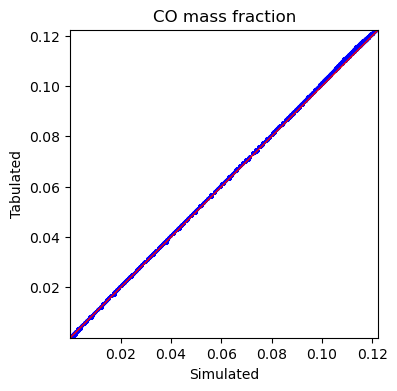

In [48]:
ScatterPlotMultipleFlames(kinetics, cfdf, "CO", recon_Y_CO, "CO mass fraction", output_folder, "Scatter_CO")
#PlotProfile(cfdf[0].Z, cfdf[0].Y[:,kinetics.species.index('CO')], cfdf[0].Z, recon_Y_CO[0], "CO mass fraction", "mixture fraction", "CO mass fraction", output_folder, "Profiles_CO")

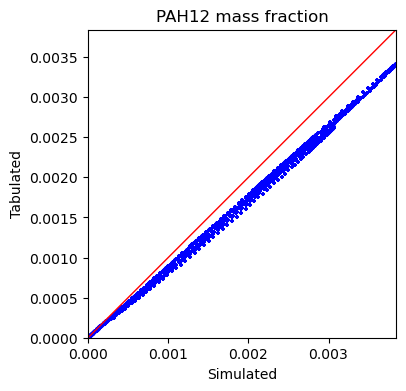

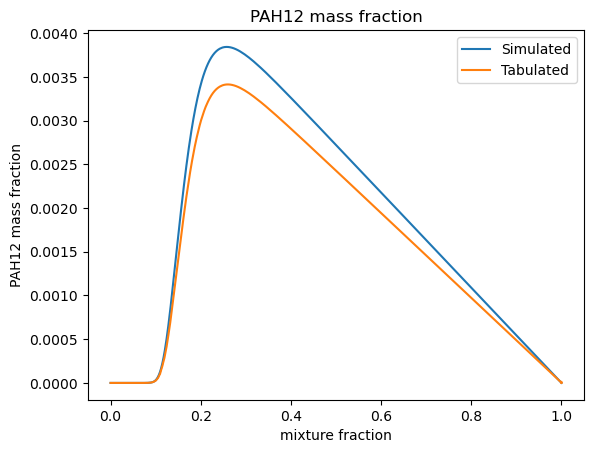

In [49]:
ScatterPlotMultipleFlames(kinetics, cfdf, "PAH12", recon_Y_PAH12, "PAH12 mass fraction", output_folder, "Scatter_PAH12")
PlotProfile(cfdf[0].Z, cfdf[0].pah12_Y, cfdf[0].Z, recon_Y_PAH12[0], "PAH12 mass fraction", "mixture fraction", "PAH12 mass fraction", output_folder, "Profiles_PAH12")

../src/TabulatedChemistry\TabulationChemistryUtilities.py:155: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(lineStart, lineEnd)
../src/TabulatedChemistry\TabulationChemistryUtilities.py:156: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim(lineStart, lineEnd)


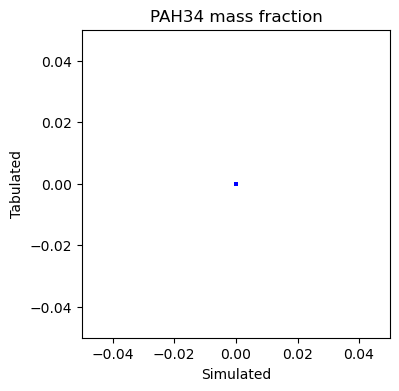

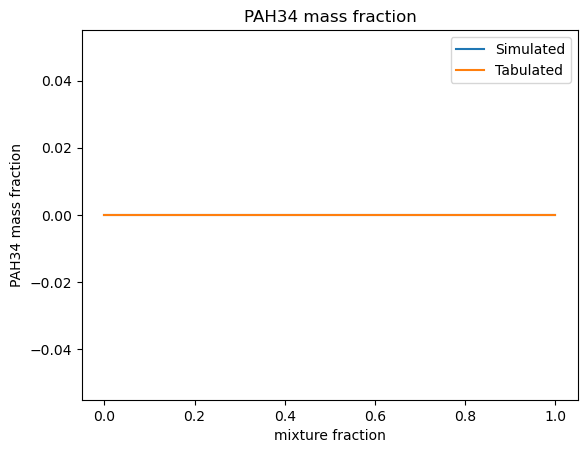

In [50]:
ScatterPlotMultipleFlames(kinetics, cfdf, "PAH34", recon_Y_PAH34, "PAH34 mass fraction", output_folder, "Scatter_PAH34")
PlotProfile(cfdf[0].Z, cfdf[0].pah34_Y, cfdf[0].Z, recon_Y_PAH34[0], "PAH34 mass fraction", "mixture fraction", "PAH34 mass fraction", output_folder, "Profiles_PAH34")

../src/TabulatedChemistry\TabulationChemistryUtilities.py:155: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(lineStart, lineEnd)
../src/TabulatedChemistry\TabulationChemistryUtilities.py:156: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim(lineStart, lineEnd)


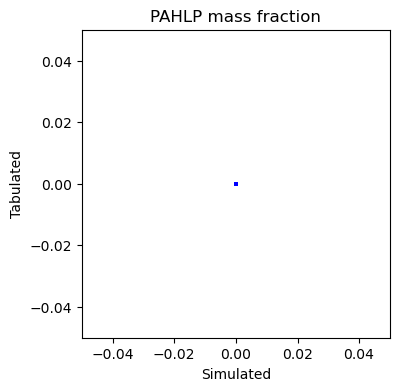

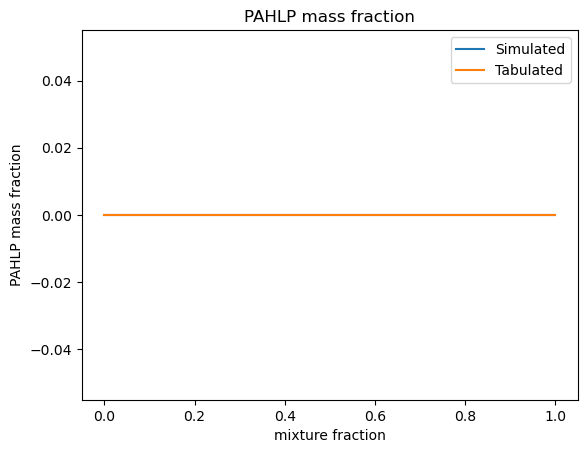

In [51]:
ScatterPlotMultipleFlames(kinetics, cfdf, "PAHLP", recon_Y_PAHLP, "PAHLP mass fraction", output_folder, "Scatter_PAHLP")
PlotProfile(cfdf[0].Z, cfdf[0].pahlp_Y, cfdf[0].Z, recon_Y_PAHLP[0], "PAHLP mass fraction", "mixture fraction", "PAHLP mass fraction", output_folder, "Profiles_PAHLP")

../src/TabulatedChemistry\TabulationChemistryUtilities.py:155: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(lineStart, lineEnd)
../src/TabulatedChemistry\TabulationChemistryUtilities.py:156: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim(lineStart, lineEnd)


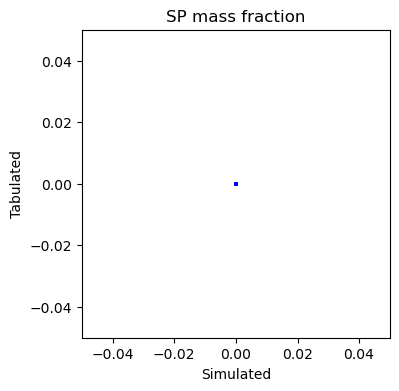

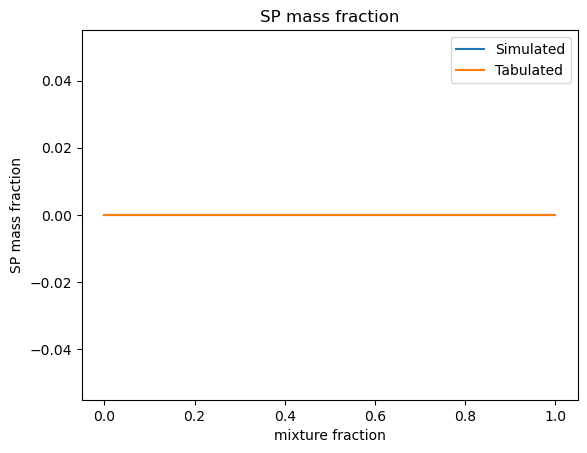

In [52]:
ScatterPlotMultipleFlames(kinetics, cfdf, "SP", recon_Y_SP, "SP mass fraction", output_folder, "Scatter_SP")
PlotProfile(cfdf[0].Z, cfdf[0].sp_Y, cfdf[0].Z, recon_Y_SP[0], "SP mass fraction", "mixture fraction", "SP mass fraction", output_folder, "Profiles_SP")

../src/TabulatedChemistry\TabulationChemistryUtilities.py:155: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(lineStart, lineEnd)
../src/TabulatedChemistry\TabulationChemistryUtilities.py:156: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim(lineStart, lineEnd)


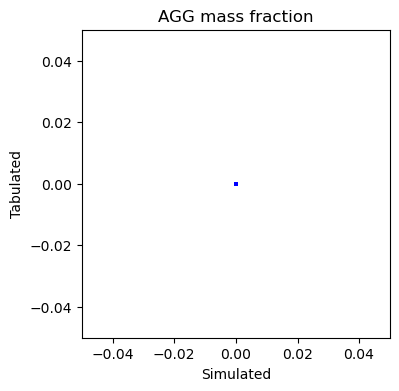

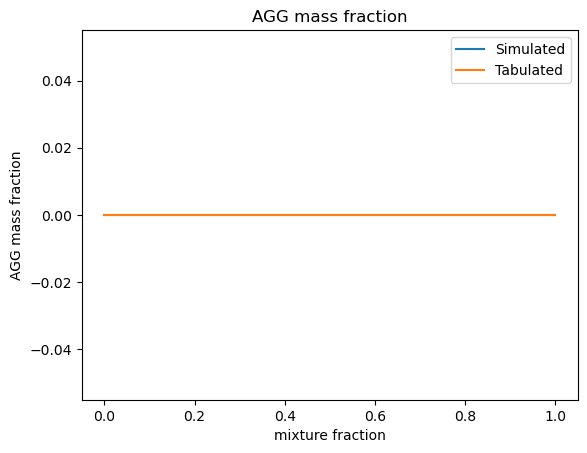

In [53]:
ScatterPlotMultipleFlames(kinetics, cfdf, "AGG", recon_Y_AGG, "AGG mass fraction", output_folder, "Scatter_AGG")
PlotProfile(cfdf[0].Z, cfdf[0].agg_Y, cfdf[0].Z, recon_Y_AGG[0], "AGG mass fraction", "mixture fraction", "AGG mass fraction", output_folder, "Profiles_AGG")

In [54]:
nrmse_T = nrmse_total(kinetics, cfdf, "T", recon_T)
nrmse_Y_CO2 = nrmse_total(kinetics, cfdf, "CO2", recon_Y_CO2)
nrmse_Y_CO = nrmse_total(kinetics, cfdf, "CO", recon_Y_CO)
nrmse_Y_H2 = nrmse_total(kinetics, cfdf, "H2", recon_Y_H2)
nrmse_Y_H2O = nrmse_total(kinetics, cfdf, "H2O", recon_Y_H2O)
nrmse_Y_C2H2 = nrmse_total(kinetics, cfdf, "C2H2", recon_Y_C2H2)

print('T:', nrmse_T)
print('CO2', nrmse_Y_CO2)
print('CO', nrmse_Y_CO)
print('H2', nrmse_Y_H2)
print('H2O', nrmse_Y_H2O)
print('C2H2', nrmse_Y_C2H2)

T: [0.00942255]
CO2 [0.00812276]
CO [0.00879826]
H2 [0.00873504]
H2O [0.00353708]
C2H2 [0.0316572]


In [55]:
nrmse_Y_PAH12 = nrmse_total(kinetics, cfdf, "PAH12", recon_Y_PAH12)
nrmse_Y_PAH34 = nrmse_total(kinetics, cfdf, "PAH34", recon_Y_PAH34)
nrmse_Y_PAHLP = nrmse_total(kinetics, cfdf, "PAHLP", recon_Y_PAHLP)
nrmse_Y_SP = nrmse_total(kinetics, cfdf, "SP", recon_Y_SP)
nrmse_Y_AGG = nrmse_total(kinetics, cfdf, "AGG", recon_Y_AGG)

print('PAH12', nrmse_Y_PAH12)
print('PAH34', nrmse_Y_PAH34)
print('PAHLP', nrmse_Y_PAHLP)
print('SP', nrmse_Y_SP)
print('AGG', nrmse_Y_AGG)

PAH12 [0.18188439]
PAH34 [nan]
PAHLP [nan]
SP [nan]
AGG [nan]


../src/TabulatedChemistry\TabulationChemistryUtilities.py:215: RuntimeWarning: invalid value encountered in true_divide
  return np.sqrt( sum_squared/len(x) ) / mu


In [56]:
f = open(output_folder + "summary.out", "w")
f.write('T     ' + str(nrmse_T) + '\n')
f.write('CO2   ' + str(nrmse_Y_CO2) + '\n')
f.write('CO    ' + str(nrmse_Y_CO) + '\n')
f.write('H2    ' + str(nrmse_Y_H2) + '\n')
f.write('H2O   ' + str(nrmse_Y_H2O) + '\n')
f.write('C2H2  ' + str(nrmse_Y_C2H2) + '\n')
f.write('PAH12 ' + str(nrmse_Y_PAH12) + '\n')
f.write('PAH34 ' + str(nrmse_Y_PAH34) + '\n')
f.write('PAHLP ' + str(nrmse_Y_PAHLP) + '\n')
f.write('SP '    + str(nrmse_Y_SP) + '\n')
f.write('AGG '   + str(nrmse_Y_AGG) + '\n')
f.close()